In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "R15m10"
station_dv = "Gum-LM RL10 (mm)"
station_path = "data/station_inputs/15min_rain_rl10_for_maps.csv"
input_model_path = (
    "data/model_inputs/rain_CanRCM4-LE_ens15_1951-2016_max1hr_rl10_gum_lm_ensmean.nc"
)
medians = {"value": 19, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = False


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,Gum-LM RL10 (mm),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,24.072803,-4.517790,10.457750,42.0333,-82.9000,190.0,HARROW CDA composite,ON,22.773129,1.164754
1,552,1017,26.248475,-4.547677,10.753982,41.9500,-82.5167,177.0,POINT PELEE composite,ON,22.839188,1.266349
2,558,1007,21.929598,-4.277531,10.287925,42.3000,-83.0667,180.0,WINDSOR UNIVERSITY,ON,22.810122,1.059335


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

nan

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 2/515 [00:00<02:43,  3.13it/s]

  1%|          | 3/515 [00:01<03:29,  2.45it/s]

  1%|          | 4/515 [00:01<03:58,  2.14it/s]

  1%|          | 5/515 [00:02<04:37,  1.84it/s]

  1%|          | 6/515 [00:03<04:44,  1.79it/s]

  1%|▏         | 7/515 [00:03<04:47,  1.77it/s]

  2%|▏         | 8/515 [00:04<04:43,  1.79it/s]

  2%|▏         | 9/515 [00:04<04:43,  1.78it/s]

  2%|▏         | 10/515 [00:05<04:43,  1.78it/s]

  2%|▏         | 11/515 [00:06<04:55,  1.71it/s]

  2%|▏         | 12/515 [00:06<05:10,  1.62it/s]

  3%|▎         | 13/515 [00:07<05:08,  1.63it/s]

  3%|▎         | 14/515 [00:07<05:06,  1.63it/s]

  3%|▎         | 15/515 [00:08<05:07,  1.62it/s]

  3%|▎         | 16/515 [00:09<04:59,  1.67it/s]

  3%|▎         | 17/515 [00:09<04:56,  1.68it/s]

  3%|▎         | 18/515 [00:10<04:51,  1.70it/s]

  4%|▎         | 19/515 [00:10<04:52,  1.70it/s]

  4%|▍         | 20/515 [00:11<04:52,  1.69it/s]

  4%|▍         | 21/515 [00:12<04:48,  1.71it/s]

  4%|▍         | 22/515 [00:12<04:45,  1.72it/s]

  4%|▍         | 23/515 [00:13<04:44,  1.73it/s]

  5%|▍         | 24/515 [00:13<04:44,  1.72it/s]

  5%|▍         | 25/515 [00:14<04:43,  1.73it/s]

  5%|▌         | 26/515 [00:14<04:37,  1.76it/s]

  5%|▌         | 27/515 [00:15<04:32,  1.79it/s]

  5%|▌         | 28/515 [00:16<04:32,  1.79it/s]

  6%|▌         | 29/515 [00:16<04:33,  1.78it/s]

  6%|▌         | 30/515 [00:17<04:36,  1.75it/s]

  6%|▌         | 31/515 [00:17<04:38,  1.74it/s]

  6%|▌         | 32/515 [00:18<04:38,  1.74it/s]

  6%|▋         | 33/515 [00:18<04:38,  1.73it/s]

  7%|▋         | 34/515 [00:19<04:36,  1.74it/s]

  7%|▋         | 35/515 [00:20<04:35,  1.74it/s]

  7%|▋         | 36/515 [00:20<04:35,  1.74it/s]

  7%|▋         | 37/515 [00:21<04:34,  1.74it/s]

  7%|▋         | 38/515 [00:21<04:36,  1.72it/s]

  8%|▊         | 39/515 [00:22<04:38,  1.71it/s]

  8%|▊         | 40/515 [00:22<04:35,  1.72it/s]

  8%|▊         | 41/515 [00:23<04:33,  1.73it/s]

  8%|▊         | 42/515 [00:24<04:38,  1.70it/s]

  8%|▊         | 43/515 [00:24<04:34,  1.72it/s]

  9%|▊         | 44/515 [00:25<04:35,  1.71it/s]

  9%|▊         | 45/515 [00:25<04:33,  1.72it/s]

  9%|▉         | 46/515 [00:26<04:36,  1.70it/s]

  9%|▉         | 47/515 [00:27<04:38,  1.68it/s]

  9%|▉         | 48/515 [00:27<04:39,  1.67it/s]

 10%|▉         | 49/515 [00:28<04:43,  1.64it/s]

 10%|▉         | 50/515 [00:28<04:47,  1.62it/s]

 10%|▉         | 51/515 [00:29<04:44,  1.63it/s]

 10%|█         | 52/515 [00:30<04:50,  1.59it/s]

 10%|█         | 53/515 [00:30<04:46,  1.61it/s]

 10%|█         | 54/515 [00:31<04:42,  1.63it/s]

 11%|█         | 55/515 [00:32<04:43,  1.62it/s]

 11%|█         | 56/515 [00:32<04:41,  1.63it/s]

 11%|█         | 57/515 [00:33<04:50,  1.58it/s]

 11%|█▏        | 58/515 [00:33<04:48,  1.58it/s]

 11%|█▏        | 59/515 [00:34<04:51,  1.57it/s]

 12%|█▏        | 60/515 [00:35<04:53,  1.55it/s]

 12%|█▏        | 61/515 [00:35<04:49,  1.57it/s]

 12%|█▏        | 62/515 [00:36<05:02,  1.50it/s]

 12%|█▏        | 63/515 [00:37<04:50,  1.56it/s]

 12%|█▏        | 64/515 [00:37<04:55,  1.53it/s]

 13%|█▎        | 65/515 [00:38<05:03,  1.48it/s]

 13%|█▎        | 66/515 [00:39<04:53,  1.53it/s]

 13%|█▎        | 67/515 [00:39<04:43,  1.58it/s]

 13%|█▎        | 68/515 [00:40<04:51,  1.53it/s]

 13%|█▎        | 69/515 [00:41<04:44,  1.57it/s]

 14%|█▎        | 70/515 [00:41<04:37,  1.60it/s]

 14%|█▍        | 71/515 [00:42<04:40,  1.58it/s]

 14%|█▍        | 72/515 [00:43<04:39,  1.58it/s]

 14%|█▍        | 73/515 [00:43<04:41,  1.57it/s]

 14%|█▍        | 74/515 [00:44<04:37,  1.59it/s]

 15%|█▍        | 75/515 [00:44<04:42,  1.55it/s]

 15%|█▍        | 76/515 [00:45<04:43,  1.55it/s]

 15%|█▍        | 77/515 [00:46<04:37,  1.58it/s]

 15%|█▌        | 78/515 [00:46<04:28,  1.63it/s]

 15%|█▌        | 79/515 [00:47<04:26,  1.64it/s]

 16%|█▌        | 80/515 [00:47<04:22,  1.65it/s]

 16%|█▌        | 81/515 [00:48<04:19,  1.67it/s]

 16%|█▌        | 82/515 [00:49<04:18,  1.68it/s]

 16%|█▌        | 83/515 [00:49<04:13,  1.71it/s]

 16%|█▋        | 84/515 [00:50<04:07,  1.74it/s]

 17%|█▋        | 85/515 [00:50<04:13,  1.69it/s]

 17%|█▋        | 86/515 [00:51<04:14,  1.69it/s]

 17%|█▋        | 87/515 [00:52<04:18,  1.65it/s]

 17%|█▋        | 88/515 [00:52<04:14,  1.68it/s]

 17%|█▋        | 89/515 [00:53<04:17,  1.65it/s]

 17%|█▋        | 90/515 [00:53<04:19,  1.64it/s]

 18%|█▊        | 91/515 [00:54<04:19,  1.63it/s]

 18%|█▊        | 92/515 [00:55<04:16,  1.65it/s]

 18%|█▊        | 93/515 [00:55<04:13,  1.66it/s]

 18%|█▊        | 94/515 [00:56<04:12,  1.67it/s]

 18%|█▊        | 95/515 [00:56<04:15,  1.64it/s]

 19%|█▊        | 96/515 [00:57<04:15,  1.64it/s]

 19%|█▉        | 97/515 [00:58<04:17,  1.63it/s]

 19%|█▉        | 98/515 [00:58<04:17,  1.62it/s]

 19%|█▉        | 99/515 [00:59<04:19,  1.60it/s]

 19%|█▉        | 100/515 [01:00<04:14,  1.63it/s]

 20%|█▉        | 101/515 [01:00<04:10,  1.65it/s]

 20%|█▉        | 102/515 [01:01<04:06,  1.67it/s]

 20%|██        | 103/515 [01:01<04:04,  1.68it/s]

 20%|██        | 104/515 [01:02<04:05,  1.67it/s]

 20%|██        | 105/515 [01:03<04:10,  1.63it/s]

 21%|██        | 106/515 [01:03<04:05,  1.66it/s]

 21%|██        | 107/515 [01:04<04:02,  1.68it/s]

 21%|██        | 108/515 [01:04<04:06,  1.65it/s]

 21%|██        | 109/515 [01:05<04:04,  1.66it/s]

 21%|██▏       | 110/515 [01:06<04:11,  1.61it/s]

 22%|██▏       | 111/515 [01:06<04:09,  1.62it/s]

 22%|██▏       | 112/515 [01:07<04:06,  1.63it/s]

 22%|██▏       | 113/515 [01:07<04:07,  1.63it/s]

 22%|██▏       | 114/515 [01:08<04:04,  1.64it/s]

 22%|██▏       | 115/515 [01:09<04:01,  1.66it/s]

 23%|██▎       | 116/515 [01:09<03:57,  1.68it/s]

 23%|██▎       | 117/515 [01:10<03:56,  1.68it/s]

 23%|██▎       | 118/515 [01:10<03:59,  1.66it/s]

 23%|██▎       | 119/515 [01:11<03:58,  1.66it/s]

 23%|██▎       | 120/515 [01:12<04:00,  1.64it/s]

 23%|██▎       | 121/515 [01:12<03:59,  1.65it/s]

 24%|██▎       | 122/515 [01:13<03:57,  1.65it/s]

 24%|██▍       | 123/515 [01:13<03:55,  1.66it/s]

 24%|██▍       | 124/515 [01:14<03:52,  1.68it/s]

 24%|██▍       | 125/515 [01:15<03:54,  1.66it/s]

 24%|██▍       | 126/515 [01:15<03:50,  1.69it/s]

 25%|██▍       | 127/515 [01:16<03:48,  1.70it/s]

 25%|██▍       | 128/515 [01:16<03:46,  1.71it/s]

 25%|██▌       | 129/515 [01:17<03:50,  1.67it/s]

 25%|██▌       | 130/515 [01:18<03:51,  1.66it/s]

 25%|██▌       | 131/515 [01:18<03:52,  1.66it/s]

 26%|██▌       | 132/515 [01:19<03:51,  1.65it/s]

 26%|██▌       | 133/515 [01:19<03:54,  1.63it/s]

 26%|██▌       | 134/515 [01:20<03:54,  1.63it/s]

 26%|██▌       | 135/515 [01:21<03:51,  1.64it/s]

 26%|██▋       | 136/515 [01:21<03:48,  1.66it/s]

 27%|██▋       | 137/515 [01:22<03:47,  1.66it/s]

 27%|██▋       | 138/515 [01:22<03:49,  1.64it/s]

 27%|██▋       | 139/515 [01:23<03:49,  1.64it/s]

 27%|██▋       | 140/515 [01:24<03:45,  1.66it/s]

 27%|██▋       | 141/515 [01:24<03:41,  1.69it/s]

 28%|██▊       | 142/515 [01:25<03:35,  1.73it/s]

 28%|██▊       | 143/515 [01:25<03:32,  1.75it/s]

 28%|██▊       | 144/515 [01:26<03:28,  1.78it/s]

 28%|██▊       | 145/515 [01:26<03:26,  1.80it/s]

 28%|██▊       | 146/515 [01:27<03:26,  1.79it/s]

 29%|██▊       | 147/515 [01:28<03:29,  1.76it/s]

 29%|██▊       | 148/515 [01:28<03:29,  1.75it/s]

 29%|██▉       | 149/515 [01:29<03:31,  1.73it/s]

 29%|██▉       | 150/515 [01:29<03:29,  1.74it/s]

 29%|██▉       | 151/515 [01:30<03:30,  1.73it/s]

 30%|██▉       | 152/515 [01:30<03:33,  1.70it/s]

 30%|██▉       | 153/515 [01:31<03:39,  1.65it/s]

 30%|██▉       | 154/515 [01:32<03:35,  1.67it/s]

 30%|███       | 155/515 [01:32<03:34,  1.68it/s]

 30%|███       | 156/515 [01:33<03:29,  1.71it/s]

 30%|███       | 157/515 [01:33<03:31,  1.70it/s]

 31%|███       | 158/515 [01:34<03:26,  1.73it/s]

 31%|███       | 159/515 [01:35<03:27,  1.71it/s]

 31%|███       | 160/515 [01:35<03:34,  1.65it/s]

 31%|███▏      | 161/515 [01:36<03:34,  1.65it/s]

 31%|███▏      | 162/515 [01:36<03:34,  1.65it/s]

 32%|███▏      | 163/515 [01:37<03:33,  1.65it/s]

 32%|███▏      | 164/515 [01:38<03:27,  1.69it/s]

 32%|███▏      | 165/515 [01:38<03:28,  1.68it/s]

 32%|███▏      | 166/515 [01:39<03:30,  1.66it/s]

 32%|███▏      | 167/515 [01:39<03:27,  1.67it/s]

 33%|███▎      | 168/515 [01:40<03:25,  1.69it/s]

 33%|███▎      | 169/515 [01:41<03:32,  1.63it/s]

 33%|███▎      | 170/515 [01:41<03:34,  1.61it/s]

 33%|███▎      | 171/515 [01:42<03:33,  1.61it/s]

 33%|███▎      | 172/515 [01:43<03:36,  1.59it/s]

 34%|███▎      | 173/515 [01:43<03:25,  1.66it/s]

 34%|███▍      | 174/515 [01:44<03:29,  1.63it/s]

 34%|███▍      | 175/515 [01:45<03:38,  1.56it/s]

 34%|███▍      | 176/515 [01:45<03:29,  1.62it/s]

 34%|███▍      | 177/515 [01:46<03:27,  1.63it/s]

 35%|███▍      | 178/515 [01:46<03:18,  1.70it/s]

 35%|███▍      | 179/515 [01:47<03:20,  1.67it/s]

 35%|███▍      | 180/515 [01:47<03:21,  1.66it/s]

 35%|███▌      | 181/515 [01:48<03:16,  1.70it/s]

 35%|███▌      | 182/515 [01:48<03:07,  1.78it/s]

 36%|███▌      | 183/515 [01:49<03:06,  1.78it/s]

 36%|███▌      | 184/515 [01:50<03:08,  1.76it/s]

 36%|███▌      | 185/515 [01:50<03:13,  1.71it/s]

 36%|███▌      | 186/515 [01:51<03:15,  1.68it/s]

 36%|███▋      | 187/515 [01:52<03:22,  1.62it/s]

 37%|███▋      | 188/515 [01:52<03:20,  1.63it/s]

 37%|███▋      | 189/515 [01:53<03:22,  1.61it/s]

 37%|███▋      | 190/515 [01:53<03:23,  1.60it/s]

 37%|███▋      | 191/515 [01:54<03:15,  1.66it/s]

 37%|███▋      | 192/515 [01:55<03:14,  1.66it/s]

 37%|███▋      | 193/515 [01:55<03:19,  1.61it/s]

 38%|███▊      | 194/515 [01:56<03:17,  1.62it/s]

 38%|███▊      | 195/515 [01:56<03:08,  1.70it/s]

 38%|███▊      | 196/515 [01:57<03:17,  1.62it/s]

 38%|███▊      | 197/515 [01:58<03:17,  1.61it/s]

 38%|███▊      | 198/515 [01:58<03:13,  1.64it/s]

 39%|███▊      | 199/515 [01:59<03:06,  1.69it/s]

 39%|███▉      | 200/515 [01:59<03:02,  1.72it/s]

 39%|███▉      | 201/515 [02:00<03:02,  1.72it/s]

 39%|███▉      | 202/515 [02:01<03:01,  1.72it/s]

 39%|███▉      | 203/515 [02:01<03:01,  1.72it/s]

 40%|███▉      | 204/515 [02:02<02:59,  1.73it/s]

 40%|███▉      | 205/515 [02:02<02:52,  1.80it/s]

 40%|████      | 206/515 [02:03<02:50,  1.82it/s]

 40%|████      | 207/515 [02:03<02:47,  1.84it/s]

 40%|████      | 208/515 [02:04<02:45,  1.85it/s]

 41%|████      | 209/515 [02:04<02:42,  1.88it/s]

 41%|████      | 210/515 [02:05<02:47,  1.82it/s]

 41%|████      | 211/515 [02:05<02:49,  1.80it/s]

 41%|████      | 212/515 [02:06<02:46,  1.81it/s]

 41%|████▏     | 213/515 [02:07<02:45,  1.82it/s]

 42%|████▏     | 214/515 [02:07<02:46,  1.81it/s]

 42%|████▏     | 215/515 [02:08<02:45,  1.82it/s]

 42%|████▏     | 216/515 [02:08<02:46,  1.79it/s]

 42%|████▏     | 217/515 [02:09<02:48,  1.77it/s]

 42%|████▏     | 218/515 [02:09<02:45,  1.80it/s]

 43%|████▎     | 219/515 [02:10<02:42,  1.82it/s]

 43%|████▎     | 220/515 [02:10<02:42,  1.81it/s]

 43%|████▎     | 221/515 [02:11<02:42,  1.80it/s]

 43%|████▎     | 222/515 [02:12<02:44,  1.78it/s]

 43%|████▎     | 223/515 [02:12<02:41,  1.80it/s]

 43%|████▎     | 224/515 [02:13<02:42,  1.80it/s]

 44%|████▎     | 225/515 [02:13<02:42,  1.78it/s]

 44%|████▍     | 226/515 [02:14<02:44,  1.76it/s]

 44%|████▍     | 227/515 [02:14<02:42,  1.77it/s]

 44%|████▍     | 228/515 [02:15<02:41,  1.78it/s]

 44%|████▍     | 229/515 [02:15<02:39,  1.80it/s]

 45%|████▍     | 230/515 [02:16<02:39,  1.78it/s]

 45%|████▍     | 231/515 [02:17<02:37,  1.80it/s]

 45%|████▌     | 232/515 [02:17<02:34,  1.83it/s]

 45%|████▌     | 233/515 [02:18<02:35,  1.81it/s]

 45%|████▌     | 234/515 [02:18<02:35,  1.80it/s]

 46%|████▌     | 235/515 [02:19<02:41,  1.73it/s]

 46%|████▌     | 236/515 [02:19<02:42,  1.72it/s]

 46%|████▌     | 237/515 [02:20<02:40,  1.73it/s]

 46%|████▌     | 238/515 [02:21<02:37,  1.76it/s]

 46%|████▋     | 239/515 [02:21<02:34,  1.79it/s]

 47%|████▋     | 240/515 [02:22<02:39,  1.72it/s]

 47%|████▋     | 241/515 [02:22<02:34,  1.77it/s]

 47%|████▋     | 242/515 [02:23<02:34,  1.77it/s]

 47%|████▋     | 243/515 [02:23<02:34,  1.76it/s]

 47%|████▋     | 244/515 [02:24<02:32,  1.78it/s]

 48%|████▊     | 245/515 [02:25<02:30,  1.79it/s]

 48%|████▊     | 246/515 [02:25<02:31,  1.78it/s]

 48%|████▊     | 247/515 [02:26<02:31,  1.77it/s]

 48%|████▊     | 248/515 [02:26<02:27,  1.81it/s]

 48%|████▊     | 249/515 [02:27<02:24,  1.84it/s]

 49%|████▊     | 250/515 [02:27<02:24,  1.83it/s]

 49%|████▊     | 251/515 [02:28<02:25,  1.81it/s]

 49%|████▉     | 252/515 [02:28<02:25,  1.81it/s]

 49%|████▉     | 253/515 [02:29<02:29,  1.76it/s]

 49%|████▉     | 254/515 [02:30<02:25,  1.80it/s]

 50%|████▉     | 255/515 [02:30<02:28,  1.76it/s]

 50%|████▉     | 256/515 [02:31<02:29,  1.74it/s]

 50%|████▉     | 257/515 [02:31<02:27,  1.75it/s]

 50%|█████     | 258/515 [02:32<03:12,  1.33it/s]

 50%|█████     | 259/515 [02:33<02:59,  1.42it/s]

 50%|█████     | 260/515 [02:34<02:46,  1.53it/s]

 51%|█████     | 261/515 [02:34<02:39,  1.59it/s]

 51%|█████     | 262/515 [02:35<02:40,  1.57it/s]

 51%|█████     | 263/515 [02:35<02:35,  1.62it/s]

 51%|█████▏    | 264/515 [02:36<02:30,  1.67it/s]

 51%|█████▏    | 265/515 [02:36<02:27,  1.69it/s]

 52%|█████▏    | 266/515 [02:37<02:27,  1.68it/s]

 52%|█████▏    | 267/515 [02:38<02:24,  1.72it/s]

 52%|█████▏    | 268/515 [02:38<02:24,  1.70it/s]

 52%|█████▏    | 269/515 [02:39<02:20,  1.76it/s]

 52%|█████▏    | 270/515 [02:39<02:19,  1.76it/s]

 53%|█████▎    | 271/515 [02:40<02:16,  1.78it/s]

 53%|█████▎    | 272/515 [02:40<02:15,  1.79it/s]

 53%|█████▎    | 273/515 [02:41<02:20,  1.72it/s]

 53%|█████▎    | 274/515 [02:42<02:20,  1.72it/s]

 53%|█████▎    | 275/515 [02:42<02:16,  1.76it/s]

 54%|█████▎    | 276/515 [02:43<02:13,  1.78it/s]

 54%|█████▍    | 277/515 [02:43<02:14,  1.77it/s]

 54%|█████▍    | 278/515 [02:44<02:11,  1.80it/s]

 54%|█████▍    | 279/515 [02:44<02:09,  1.82it/s]

 54%|█████▍    | 280/515 [02:45<02:10,  1.80it/s]

 55%|█████▍    | 281/515 [02:46<03:05,  1.26it/s]

 55%|█████▍    | 282/515 [02:47<03:32,  1.10it/s]

 55%|█████▍    | 283/515 [02:48<03:08,  1.23it/s]

 55%|█████▌    | 284/515 [02:49<02:47,  1.38it/s]

 55%|█████▌    | 285/515 [02:49<02:35,  1.48it/s]

 56%|█████▌    | 286/515 [02:50<02:29,  1.53it/s]

 56%|█████▌    | 287/515 [02:50<02:22,  1.60it/s]

 56%|█████▌    | 288/515 [02:51<02:14,  1.69it/s]

 56%|█████▌    | 289/515 [02:51<02:12,  1.71it/s]

 56%|█████▋    | 290/515 [02:52<02:09,  1.73it/s]

 57%|█████▋    | 291/515 [02:53<03:05,  1.21it/s]

 57%|█████▋    | 292/515 [02:54<02:44,  1.35it/s]

 57%|█████▋    | 293/515 [02:54<02:31,  1.46it/s]

 57%|█████▋    | 294/515 [02:55<02:24,  1.53it/s]

 57%|█████▋    | 295/515 [02:56<02:16,  1.61it/s]

 57%|█████▋    | 296/515 [02:56<02:09,  1.69it/s]

 58%|█████▊    | 297/515 [02:57<02:05,  1.74it/s]

 58%|█████▊    | 298/515 [02:57<02:07,  1.71it/s]

 58%|█████▊    | 299/515 [02:58<02:03,  1.74it/s]

 58%|█████▊    | 300/515 [02:58<02:02,  1.76it/s]

 58%|█████▊    | 301/515 [02:59<01:58,  1.80it/s]

 59%|█████▊    | 302/515 [02:59<01:58,  1.80it/s]

 59%|█████▉    | 303/515 [03:00<01:55,  1.83it/s]

 59%|█████▉    | 304/515 [03:00<01:54,  1.84it/s]

 59%|█████▉    | 305/515 [03:01<01:55,  1.81it/s]

 59%|█████▉    | 306/515 [03:02<01:55,  1.81it/s]

 60%|█████▉    | 307/515 [03:02<01:53,  1.83it/s]

 60%|█████▉    | 308/515 [03:04<02:57,  1.16it/s]

 60%|██████    | 309/515 [03:04<02:39,  1.29it/s]

 60%|██████    | 310/515 [03:05<02:28,  1.38it/s]

 60%|██████    | 311/515 [03:06<02:47,  1.22it/s]

 61%|██████    | 312/515 [03:08<03:32,  1.05s/it]

 61%|██████    | 313/515 [03:08<03:04,  1.10it/s]

 61%|██████    | 314/515 [03:09<03:14,  1.03it/s]

 61%|██████    | 315/515 [03:10<03:24,  1.02s/it]

 61%|██████▏   | 316/515 [03:11<03:27,  1.04s/it]

 62%|██████▏   | 317/515 [03:12<02:56,  1.12it/s]

 62%|██████▏   | 318/515 [03:13<03:07,  1.05it/s]

 62%|██████▏   | 319/515 [03:14<02:45,  1.19it/s]

 62%|██████▏   | 320/515 [03:14<02:28,  1.32it/s]

 62%|██████▏   | 321/515 [03:15<02:44,  1.18it/s]

 63%|██████▎   | 322/515 [03:16<02:58,  1.08it/s]

 63%|██████▎   | 323/515 [03:18<03:15,  1.02s/it]

 63%|██████▎   | 324/515 [03:18<02:49,  1.12it/s]

 63%|██████▎   | 325/515 [03:19<02:31,  1.26it/s]

 63%|██████▎   | 326/515 [03:19<02:18,  1.36it/s]

 63%|██████▎   | 327/515 [03:20<02:05,  1.49it/s]

 64%|██████▎   | 328/515 [03:20<01:58,  1.58it/s]

 64%|██████▍   | 329/515 [03:22<02:24,  1.29it/s]

 64%|██████▍   | 330/515 [03:23<02:38,  1.17it/s]

 64%|██████▍   | 331/515 [03:24<03:00,  1.02it/s]

 64%|██████▍   | 332/515 [03:24<02:37,  1.16it/s]

 65%|██████▍   | 333/515 [03:25<02:20,  1.30it/s]

 65%|██████▍   | 334/515 [03:26<02:34,  1.17it/s]

 65%|██████▌   | 335/515 [03:27<02:44,  1.09it/s]

 65%|██████▌   | 336/515 [03:28<02:50,  1.05it/s]

 65%|██████▌   | 337/515 [03:30<03:09,  1.06s/it]

 66%|██████▌   | 338/515 [03:30<02:41,  1.09it/s]

 66%|██████▌   | 339/515 [03:31<02:21,  1.24it/s]

 66%|██████▌   | 340/515 [03:31<02:07,  1.37it/s]

 66%|██████▌   | 341/515 [03:32<02:30,  1.15it/s]

 66%|██████▋   | 342/515 [03:34<02:48,  1.02it/s]

 67%|██████▋   | 343/515 [03:34<02:28,  1.16it/s]

 67%|██████▋   | 344/515 [03:35<02:11,  1.30it/s]

 67%|██████▋   | 345/515 [03:35<02:00,  1.41it/s]

 67%|██████▋   | 346/515 [03:36<01:54,  1.48it/s]

 67%|██████▋   | 347/515 [03:37<02:20,  1.20it/s]

 68%|██████▊   | 348/515 [03:38<02:38,  1.06it/s]

 68%|██████▊   | 349/515 [03:39<02:18,  1.20it/s]

 68%|██████▊   | 350/515 [03:39<02:03,  1.34it/s]

 68%|██████▊   | 351/515 [03:41<02:19,  1.18it/s]

 68%|██████▊   | 352/515 [03:42<02:28,  1.10it/s]

 69%|██████▊   | 353/515 [03:42<02:11,  1.24it/s]

 69%|██████▊   | 354/515 [03:43<02:32,  1.05it/s]

 69%|██████▉   | 355/515 [03:44<02:17,  1.16it/s]

 69%|██████▉   | 356/515 [03:45<02:02,  1.30it/s]

 69%|██████▉   | 357/515 [03:45<01:52,  1.41it/s]

 70%|██████▉   | 358/515 [03:46<01:46,  1.47it/s]

 70%|██████▉   | 359/515 [03:46<01:43,  1.50it/s]

 70%|██████▉   | 360/515 [03:47<01:39,  1.56it/s]

 70%|███████   | 361/515 [03:48<01:34,  1.64it/s]

 70%|███████   | 362/515 [03:48<01:32,  1.66it/s]

 70%|███████   | 363/515 [03:49<01:28,  1.71it/s]

 71%|███████   | 364/515 [03:49<01:27,  1.73it/s]

 71%|███████   | 365/515 [03:50<01:28,  1.70it/s]

 71%|███████   | 366/515 [03:50<01:25,  1.74it/s]

 71%|███████▏  | 367/515 [03:51<01:25,  1.72it/s]

 71%|███████▏  | 368/515 [03:52<01:41,  1.45it/s]

 72%|███████▏  | 369/515 [03:53<01:38,  1.48it/s]

 72%|███████▏  | 370/515 [03:53<01:34,  1.54it/s]

 72%|███████▏  | 371/515 [03:54<01:29,  1.61it/s]

 72%|███████▏  | 372/515 [03:54<01:29,  1.60it/s]

 72%|███████▏  | 373/515 [03:55<01:48,  1.31it/s]

 73%|███████▎  | 374/515 [03:57<02:16,  1.04it/s]

 73%|███████▎  | 375/515 [03:58<02:23,  1.03s/it]

 73%|███████▎  | 376/515 [03:59<02:02,  1.13it/s]

 73%|███████▎  | 377/515 [03:59<01:48,  1.27it/s]

 73%|███████▎  | 378/515 [04:00<01:55,  1.19it/s]

 74%|███████▎  | 379/515 [04:01<01:45,  1.29it/s]

 74%|███████▍  | 380/515 [04:01<01:36,  1.40it/s]

 74%|███████▍  | 381/515 [04:02<01:29,  1.50it/s]

 74%|███████▍  | 382/515 [04:02<01:22,  1.62it/s]

 74%|███████▍  | 383/515 [04:04<01:58,  1.11it/s]

 75%|███████▍  | 384/515 [04:05<01:45,  1.24it/s]

 75%|███████▍  | 385/515 [04:05<01:37,  1.33it/s]

 75%|███████▍  | 386/515 [04:06<01:32,  1.39it/s]

 75%|███████▌  | 387/515 [04:06<01:25,  1.49it/s]

 75%|███████▌  | 388/515 [04:07<01:20,  1.58it/s]

 76%|███████▌  | 389/515 [04:07<01:16,  1.65it/s]

 76%|███████▌  | 390/515 [04:08<01:13,  1.69it/s]

 76%|███████▌  | 391/515 [04:09<01:13,  1.69it/s]

 76%|███████▌  | 392/515 [04:09<01:10,  1.73it/s]

 76%|███████▋  | 393/515 [04:10<01:10,  1.72it/s]

 77%|███████▋  | 394/515 [04:10<01:09,  1.74it/s]

 77%|███████▋  | 395/515 [04:11<01:09,  1.73it/s]

 77%|███████▋  | 396/515 [04:11<01:08,  1.73it/s]

 77%|███████▋  | 397/515 [04:12<01:07,  1.76it/s]

 77%|███████▋  | 398/515 [04:13<01:06,  1.76it/s]

 77%|███████▋  | 399/515 [04:13<01:05,  1.77it/s]

 78%|███████▊  | 400/515 [04:14<01:05,  1.76it/s]

 78%|███████▊  | 401/515 [04:14<01:05,  1.74it/s]

 78%|███████▊  | 402/515 [04:15<01:08,  1.64it/s]

 78%|███████▊  | 403/515 [04:16<01:08,  1.64it/s]

 78%|███████▊  | 404/515 [04:16<01:05,  1.68it/s]

 79%|███████▊  | 405/515 [04:17<01:03,  1.73it/s]

 79%|███████▉  | 406/515 [04:17<01:03,  1.72it/s]

 79%|███████▉  | 407/515 [04:18<01:04,  1.67it/s]

 79%|███████▉  | 408/515 [04:19<01:04,  1.67it/s]

 79%|███████▉  | 409/515 [04:20<01:21,  1.30it/s]

 80%|███████▉  | 410/515 [04:20<01:15,  1.39it/s]

 80%|███████▉  | 411/515 [04:21<01:11,  1.46it/s]

 80%|████████  | 412/515 [04:21<01:05,  1.57it/s]

 80%|████████  | 413/515 [04:22<01:02,  1.62it/s]

 80%|████████  | 414/515 [04:23<01:00,  1.66it/s]

 81%|████████  | 415/515 [04:24<01:27,  1.14it/s]

 81%|████████  | 416/515 [04:25<01:16,  1.29it/s]

 81%|████████  | 417/515 [04:25<01:10,  1.40it/s]

 81%|████████  | 418/515 [04:26<01:05,  1.48it/s]

 81%|████████▏ | 419/515 [04:26<01:01,  1.55it/s]

 82%|████████▏ | 420/515 [04:27<00:58,  1.62it/s]

 82%|████████▏ | 421/515 [04:28<00:57,  1.63it/s]

 82%|████████▏ | 422/515 [04:28<00:57,  1.63it/s]

 82%|████████▏ | 423/515 [04:29<00:57,  1.59it/s]

 82%|████████▏ | 424/515 [04:29<00:56,  1.61it/s]

 83%|████████▎ | 425/515 [04:30<00:57,  1.57it/s]

 83%|████████▎ | 426/515 [04:31<01:03,  1.40it/s]

 83%|████████▎ | 427/515 [04:32<00:59,  1.47it/s]

 83%|████████▎ | 428/515 [04:32<00:57,  1.51it/s]

 83%|████████▎ | 429/515 [04:33<00:53,  1.61it/s]

 83%|████████▎ | 430/515 [04:33<00:52,  1.63it/s]

 84%|████████▎ | 431/515 [04:34<00:49,  1.68it/s]

 84%|████████▍ | 432/515 [04:34<00:49,  1.68it/s]

 84%|████████▍ | 433/515 [04:35<00:49,  1.66it/s]

 84%|████████▍ | 434/515 [04:36<00:48,  1.66it/s]

 84%|████████▍ | 435/515 [04:37<01:10,  1.13it/s]

 85%|████████▍ | 436/515 [04:38<01:04,  1.22it/s]

 85%|████████▍ | 437/515 [04:39<01:17,  1.01it/s]

 85%|████████▌ | 438/515 [04:40<01:10,  1.10it/s]

 85%|████████▌ | 439/515 [04:41<01:04,  1.18it/s]

 85%|████████▌ | 440/515 [04:41<00:57,  1.31it/s]

 86%|████████▌ | 441/515 [04:42<00:52,  1.40it/s]

 86%|████████▌ | 442/515 [04:43<01:00,  1.21it/s]

 86%|████████▌ | 443/515 [04:44<00:57,  1.25it/s]

 86%|████████▌ | 444/515 [04:44<00:52,  1.36it/s]

 86%|████████▋ | 445/515 [04:45<00:48,  1.45it/s]

 87%|████████▋ | 446/515 [04:46<00:46,  1.48it/s]

 87%|████████▋ | 447/515 [04:46<00:45,  1.50it/s]

 87%|████████▋ | 448/515 [04:47<00:44,  1.50it/s]

 87%|████████▋ | 449/515 [04:48<00:52,  1.25it/s]

 87%|████████▋ | 450/515 [04:49<00:48,  1.35it/s]

 88%|████████▊ | 451/515 [04:49<00:44,  1.45it/s]

 88%|████████▊ | 452/515 [04:51<01:02,  1.02it/s]

 88%|████████▊ | 453/515 [04:51<00:54,  1.14it/s]

 88%|████████▊ | 454/515 [04:53<01:07,  1.11s/it]

 88%|████████▊ | 455/515 [04:54<01:09,  1.15s/it]

 89%|████████▊ | 456/515 [04:55<00:57,  1.02it/s]

 89%|████████▊ | 457/515 [04:56<01:06,  1.14s/it]

 89%|████████▉ | 458/515 [04:57<00:54,  1.05it/s]

 89%|████████▉ | 459/515 [04:57<00:46,  1.19it/s]

 89%|████████▉ | 460/515 [04:59<00:57,  1.04s/it]

 90%|████████▉ | 461/515 [05:00<00:48,  1.11it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.254 0 0.251



 90%|████████▉ | 462/515 [05:00<00:39,  1.34it/s]

 90%|████████▉ | 463/515 [05:01<00:36,  1.43it/s]

 90%|█████████ | 464/515 [05:01<00:33,  1.51it/s]

 90%|█████████ | 465/515 [05:03<00:45,  1.09it/s]

 90%|█████████ | 466/515 [05:04<00:45,  1.08it/s]

 91%|█████████ | 467/515 [05:05<00:45,  1.06it/s]

 91%|█████████ | 468/515 [05:05<00:38,  1.21it/s]

 91%|█████████ | 469/515 [05:07<00:47,  1.03s/it]

 91%|█████████▏| 470/515 [05:08<00:52,  1.17s/it]

 91%|█████████▏| 471/515 [05:09<00:45,  1.03s/it]

 92%|█████████▏| 472/515 [05:10<00:51,  1.19s/it]

 92%|█████████▏| 473/515 [05:11<00:46,  1.10s/it]

 92%|█████████▏| 474/515 [05:12<00:39,  1.05it/s]

 92%|█████████▏| 475/515 [05:12<00:33,  1.20it/s]

 92%|█████████▏| 476/515 [05:14<00:38,  1.02it/s]

 93%|█████████▎| 477/515 [05:15<00:38,  1.02s/it]

 93%|█████████▎| 478/515 [05:16<00:36,  1.02it/s]

 93%|█████████▎| 479/515 [05:16<00:30,  1.17it/s]

 93%|█████████▎| 480/515 [05:17<00:28,  1.24it/s]

 93%|█████████▎| 481/515 [05:18<00:25,  1.34it/s]

 94%|█████████▎| 482/515 [05:19<00:29,  1.11it/s]

 94%|█████████▍| 483/515 [05:20<00:26,  1.19it/s]

 94%|█████████▍| 484/515 [05:20<00:26,  1.18it/s]

 94%|█████████▍| 485/515 [05:22<00:29,  1.01it/s]

 94%|█████████▍| 486/515 [05:23<00:31,  1.07s/it]

 95%|█████████▍| 487/515 [05:24<00:31,  1.13s/it]

 95%|█████████▍| 488/515 [05:26<00:31,  1.15s/it]

 95%|█████████▍| 489/515 [05:26<00:27,  1.05s/it]

 95%|█████████▌| 490/515 [05:27<00:26,  1.06s/it]

 95%|█████████▌| 491/515 [05:28<00:23,  1.01it/s]

 96%|█████████▌| 492/515 [05:29<00:22,  1.03it/s]

 96%|█████████▌| 493/515 [05:30<00:21,  1.01it/s]

 96%|█████████▌| 494/515 [05:31<00:20,  1.01it/s]

 96%|█████████▌| 495/515 [05:32<00:21,  1.08s/it]

 96%|█████████▋| 496/515 [05:34<00:21,  1.12s/it]

 97%|█████████▋| 497/515 [05:35<00:21,  1.19s/it]

 97%|█████████▋| 498/515 [05:36<00:20,  1.22s/it]

 97%|█████████▋| 499/515 [05:37<00:19,  1.20s/it]

 97%|█████████▋| 500/515 [05:39<00:19,  1.30s/it]

 97%|█████████▋| 501/515 [05:40<00:17,  1.25s/it]

 97%|█████████▋| 502/515 [05:41<00:16,  1.24s/it]

 98%|█████████▊| 503/515 [05:43<00:15,  1.28s/it]

 98%|█████████▊| 504/515 [05:44<00:13,  1.22s/it]

 98%|█████████▊| 505/515 [05:45<00:12,  1.21s/it]

 98%|█████████▊| 506/515 [05:47<00:11,  1.33s/it]

 98%|█████████▊| 507/515 [05:48<00:09,  1.25s/it]

 99%|█████████▊| 508/515 [05:49<00:09,  1.34s/it]

 99%|█████████▉| 509/515 [05:50<00:07,  1.25s/it]

 99%|█████████▉| 510/515 [05:52<00:06,  1.29s/it]

 99%|█████████▉| 511/515 [05:53<00:05,  1.42s/it]

 99%|█████████▉| 512/515 [05:55<00:04,  1.38s/it]

100%|█████████▉| 513/515 [05:56<00:02,  1.41s/it]

100%|█████████▉| 514/515 [05:59<00:01,  1.73s/it]

100%|██████████| 515/515 [06:00<00:00,  1.66s/it]

100%|██████████| 515/515 [06:02<00:00,  1.42it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'R15m10 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

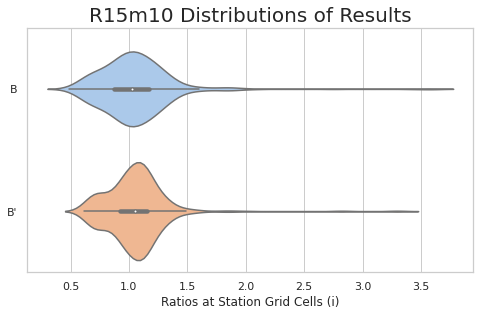

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 4.170842161200755 
UAA_station_mean nan 
Combined nan


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: mm/h


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)